# Case Study 4 : Data Science in NYC Taxi and Uber Data

**Required Readings:** 
* [Analyzing 1.1 Billion NYC Taxi and Uber Trips](http://toddwschneider.com/posts/analyzing-1-1-billion-nyc-taxi-and-uber-trips-with-a-vengeance/) 
* Please download the NYC taxi and Uber dataset from [here](https://github.com/toddwschneider/nyc-taxi-data).
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.


** NOTE **
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem: pick a data science problem that you plan to solve using Uber/Taxi Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

__Insert description of problem here__

# Data Exploration: Exploring the Uber/Taxi Dataset

** plot the spatial distribution of the pickup locations of 5000 Uber trips** 
* collect a set of 5000 Uber trips
* plot the distribution of the pickup locations using a scatter plot figure.

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

# Read from csv file, make latitude and longitude lists
with open('data/uber-raw-data-sep14.csv') as infile:
    reader = csv.DictReader(infile)
    pickups_lat = []
    pickups_long = []
    i = 0
    for line in reader:
        pickups_lat.append(float(line['Lat']))
        pickups_long.append(float(line['Lon']))
        i += 1 
        if i >= 7500: # Takes 7500 data points from Sept2014
            break

# Set up map
fig, ax = plt.subplots(figsize=(18,18))      
map = Basemap(projection='mill',
            llcrnrlat = 40.55,
            llcrnrlon = -74.3,
            urcrnrlat = 40.9,
            urcrnrlon = -73.7,
            resolution='c')

map.drawmapboundary(fill_color = 'snow')
map.readshapefile('nyc_shapefile/nyc', 'nyc')

# Separate water and land polygons in shapefile
water_patches = []
land_patches = []
water_tiles = [13936, 7906, 3830, 1456, 1311, 581, 291, 120, 107, 19]

# Color shapefile polygons
for info, shape in zip(map.nyc_info, map.nyc):
    if len(shape) in water_tiles:
        water_patches.append(Polygon(np.array(shape), True))
    else: 
        land_patches.append(Polygon(np.array(shape), True))
ax.add_collection(PatchCollection(water_patches, facecolor= 'navy', edgecolor='k', linewidths=0.3, zorder=2))
ax.add_collection(PatchCollection(land_patches, facecolor= 'snow', edgecolor='k', linewidths=0.3, zorder=2))

# Add Uber pickup datapoints
x,y = map(pickups_long, pickups_lat)
map.scatter(x,y, marker = '.', color = 'blueviolet', )

# Adjust data set to 5000 observations
pickups_lat_sp = pickups_lat[:5000]
pickups_long_sp = pickups_long[:5000]

# Creating Scatter Plot
plt.figure(figsize=(10, 8))
plt.plot(pickups_long_sp, pickups_lat_sp, 'r.')
plt.ylabel('Pickup Latitude')
plt.xlabel('Pickup Longitude')

# Show Plots
plt.show()

ImportError: No module named basemap

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

__Insert implementation description here__

Write codes to implement the solution in python:

In [32]:
# Do NOT run this cell again unless collecting new data
# It has already been aggregated and saved

import os, sys, csv, datetime, json
import cPickle as pickle
import numpy as np

# Local path to data in project folder
data_dir = 'data/'

# Get each data file path
data_files = [os.path.abspath(os.path.join(data_dir, file)) for file in os.listdir(data_dir)]

# Average data storage by month
avg_dist = dict()
avg_time = dict()
avg_fare = dict()

# Initialization
for i in range(1, 13):
    avg_dist[i] = []
    avg_time[i] = []
    avg_fare[i] = []

def parse_date(s):
        """
        Returns a datetime instance of the formatted data.
        
        Arguments:
            s: The string date.
        Returns: a datetime
        """
        # Potential formats in the taxi data
        date_formats = ('%m/%d/%Y %H:%M', '%Y-%m-%d %H:%M:%S')
        
        # Try each format
        for date_format in date_formats:
            try:
                return datetime.datetime.strptime(s, date_format)
            except ValueError:
                pass
        return None


file_id = 0
file_switch = 6 # Data format for files in 2016 changes in July (zero based)

# Read each file
for data_file in data_files:
    with open(data_file, 'r') as f:
        reader = csv.reader(f)
        next(reader) # Skip header
        
        row_id = 0
        # Read each record
        for row in reader:
            # If bad data
            if not row:
                continue
            
            # Parse columns
            pickup_date = parse_date(row[1])
            dropoff_date = parse_date(row[2])
            month = pickup_date.month
            dist = float(row[4])
            
            # Read fare from different column depending on file format
            # File format changed and it is not documented in:
            # http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf
            fare = 0.0
            if file_id >= file_switch:
                fare = float(row[16])
            else:
                fare = float(row[18])

            # Get trip time in minutes from pickup and dropoff times
            trip_time = (dropoff_date - pickup_date).total_seconds() / 60

            # Store averages by month
            avg_dist[month].append(dist)
            avg_time[month].append(trip_time)
            avg_fare[month].append(fare)
            
            row_id += 1

    # Track file index
    file_id += 1
    print 'Finished {} at {}.'.format(data_file, datetime.datetime.now())

def convert_dict_to_avgs(item_dict):
    """
    Converts the array data in average dictionaries into averages for each month.
    
    Arguments:
        items_dict: The dictionary to convert.
    """
    for key in item_dict.keys():
        avg = 0.0
        
        # If there are items to average
        if len(item_dict[key]) > 0:
            avg = np.average(item_dict[key])
        item_dict[key] = avg

convert_dict_to_avgs(avg_dist)
convert_dict_to_avgs(avg_time)
convert_dict_to_avgs(avg_fare)

# Data format
avg_data = {
    'avg_dist': avg_dist,
    'avg_time': avg_time,
    'avg_fare': avg_fare
}

output_file = 'avg_output'

# Write averages data to output file
# Only run for new data, previous file is already saved
write_output = False
if write_output:
    with open(output_file, 'wb') as f:
        pickle.dump(avg_data, f)
        print 'Wrote data.'

Finished D:\Users\Aditya\Programming\DS3001-Case-4\data\yellow_tripdata_2016-01.csv.
Finished D:\Users\Aditya\Programming\DS3001-Case-4\data\yellow_tripdata_2016-02.csv.
Finished D:\Users\Aditya\Programming\DS3001-Case-4\data\yellow_tripdata_2016-03.csv.
Finished D:\Users\Aditya\Programming\DS3001-Case-4\data\yellow_tripdata_2016-04.csv.
Finished D:\Users\Aditya\Programming\DS3001-Case-4\data\yellow_tripdata_2016-05.csv.
Finished D:\Users\Aditya\Programming\DS3001-Case-4\data\yellow_tripdata_2016-06.csv.
Finished D:\Users\Aditya\Programming\DS3001-Case-4\data\yellow_tripdata_2016-07.csv.
Finished D:\Users\Aditya\Programming\DS3001-Case-4\data\yellow_tripdata_2016-08.csv.
Finished D:\Users\Aditya\Programming\DS3001-Case-4\data\yellow_tripdata_2016-09.csv.
Finished D:\Users\Aditya\Programming\DS3001-Case-4\data\yellow_tripdata_2016-10.csv.
Finished D:\Users\Aditya\Programming\DS3001-Case-4\data\yellow_tripdata_2016-11.csv.
Finished D:\Users\Aditya\Programming\DS3001-Case-4\data\yellow_tr

Loaded data.


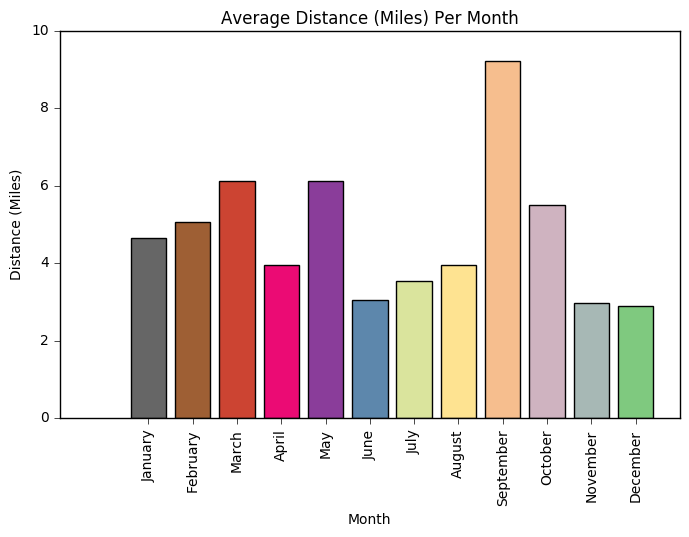

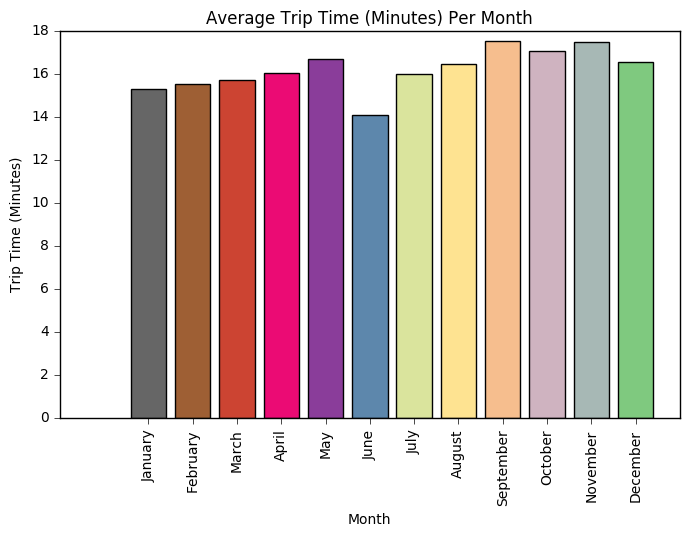

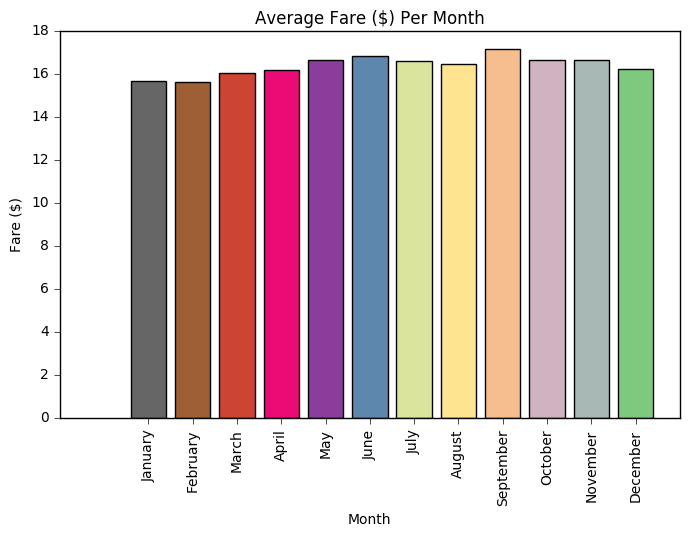

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import calendar
import cPickle as pickle

output_file = 'avg_output'

def make_avg_chart(months, average_dict, info_type, stat_keyword):
    """
    Creates a bar chart across the months for the specified dictionary of data.
    
    Arguments:
        months: The sorted IDs of the months.
        average_dict: The dictionary to be plotted.
        info_type: The title label of the data being plotted.
        stat_keyword: The type of statistics shown on the plotted data.
    """
    plt.figure(figsize=(8, 5))

    # Get months and averages
    month_ids = [calendar.month_name[month] for month in months]
    avgs = [average_dict[month] for month in months]

    # Get colors
    cmap = plt.get_cmap('Accent_r')
    colors = [cmap(i) for i in np.linspace(0, 1, len(month_ids))]
    months_len = range(len(month_ids))

    # Bar chart
    plt.bar(months_len, avgs, align='center', color=colors)
    
    # Labels
    locs, labels = plt.xticks(months_len, month_ids)
    plt.setp(labels, rotation=90)
    plt.title('{} {} Per Month'.format(stat_keyword, info_type))
    plt.tick_params(axis='x', which='both', top='off')
    plt.tick_params(axis='y', which='both', right='off')
    
    # Axes
    ax = plt.gca()
    ax.tick_params(direction='out')
    ax.set_xlabel('Month')
    ax.set_ylabel(info_type)
    
    plt.show()

avg_dist = None
avg_time = None
avg_fare = None
    
# Load data
with open(output_file, 'r') as f:    
    avg_data = pickle.load(f)
    avg_dist = avg_data['avg_dist']
    avg_time = avg_data['avg_time']
    avg_fare = avg_data['avg_fare']
    
    print 'Loaded data.'
    
    # Get month IDs sorted
    months = sorted(avg_dist.keys(), reverse=False)
    
    # Make charts
    make_avg_chart(months, avg_dist, 'Distance (Miles)', 'Average')
    make_avg_chart(months, avg_time, 'Trip Time (Minutes)', 'Average')
    make_avg_chart(months, avg_fare, 'Fare ($)', 'Average')

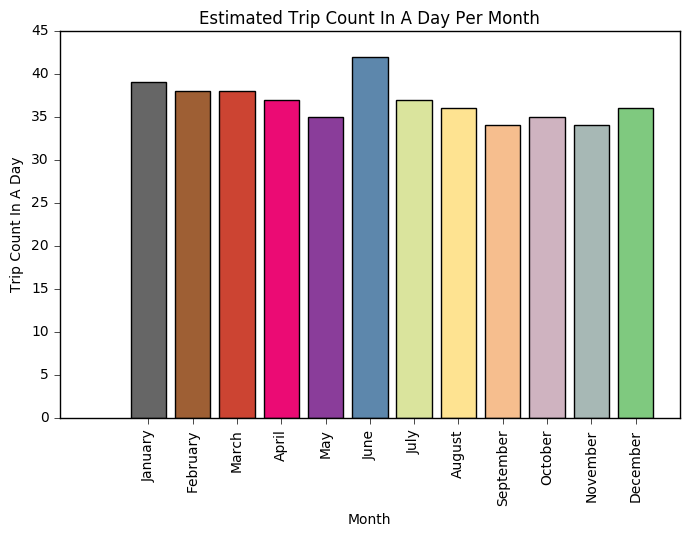

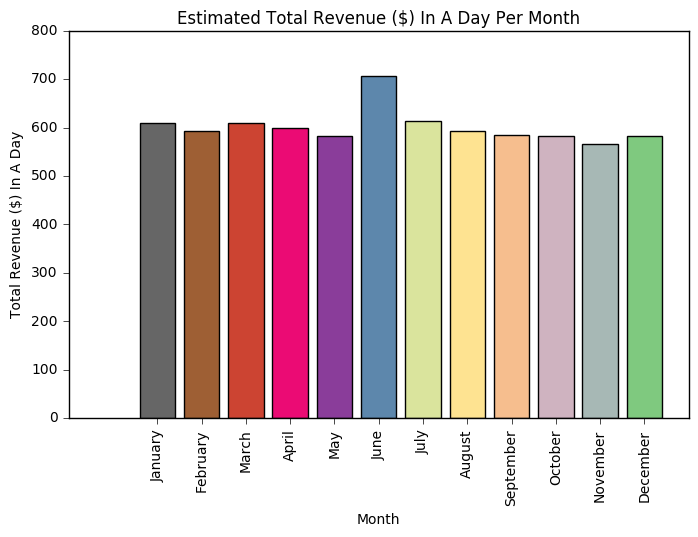

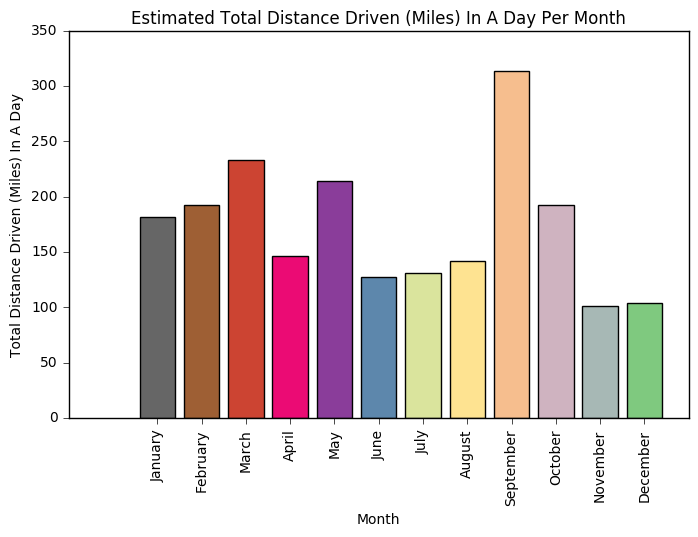

In [10]:
import math

# Defines the number of working hours for a taxi driver
taxi_work_hours = 10.0
taxi_work_time = taxi_work_hours * 60.0 # Convert to minutes
taxi_trip_break = 0.0 # Minutes of break between each fare completed

avg_trips_count = dict()

# Based on average time per trip, calculate estimate of number of trips that can be done
# in a working day
for key in avg_time.keys():
    avg_trips_count[key] = math.floor(taxi_work_time / (avg_time[key] + taxi_trip_break))

make_avg_chart(months, avg_trips_count, 'Trip Count In A Day', 'Estimated')

# Calculate cumulative revenue from fares based on number of estimated trips per day
sum_fare_revenue = dict()
for key in avg_fare.keys():
    sum_fare_revenue[key] = avg_fare[key] * avg_trips_count[key]

make_avg_chart(months, sum_fare_revenue, 'Total Revenue ($) In A Day', 'Estimated')

# Calculate cumulative distance traveled based on number of estimated trips per day
sum_dist_driven = dict()
for key in avg_dist.keys():
    sum_dist_driven[key] = avg_dist[key] * avg_trips_count[key]

make_avg_chart(months, sum_dist_driven, 'Total Distance Driven (Miles) In A Day', 'Estimated')

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


In [1]:
# Data needed for formula:
# avg_trips_count, sum_fare_revenue, sum_dist_driven

print avg_trips_count

# Calculate cumulative revenue from fares based on number of estimated trips per day
sum_fare_profit = dict()
for key in sum_fare_revenue.keys():
    sum_fare_profit[key] = sum_fare_revenue[key] - sum_dist_driven[key] * .54

make_avg_chart(months, sum_fare_profit, 'Total Profit ($) In A Day', 'Estimated')

#Now, how long does it take for a taxi driver to make money?

total_yearly_profit = 0
for key in sum_fare_profit.keys():
    total_yearly_profit += sum_fare_profit[key]
    
print total_yearly_profit

# Each is a dictionary of key=month ID in range [1, 12], value=associated estimate/average
# value per day in that month for that dictionary

NameError: name 'avg_trips_count' is not defined

*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 4".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (10 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect/process
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    
    (1) plot the spatial distribution of the pickup locations of 5000 Uber trips (10 points):
       0: missing answer
       4: okay, but with major problems
       7: good, but with minor problems
      10: perfect
    

    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9


